In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler


from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

## Days analysis
### January 30th 2019, workday

In [2]:
df_data = pd.read_csv('data/comed_month/comed_201901.csv')

In [3]:
df_data

,zip5,n_acc,service_name,date_time,energy
0,60002,198,COM KWH ONLY,2019-01-01 00:30:00,34.7298
1,60002,34,MED (100 - 400),2019-01-01 00:30:00,714.8298
2,60002,479,RESIDENTIAL MULTI,2019-01-01 00:30:00,101.3743
3,60002,538,RESIDENTIAL MULTI (SPACE HEAT),2019-01-01 00:30:00,312.1044
4,60002,9255,RESIDENTIAL SINGLE,2019-01-01 00:30:00,4651.0685
...,...,...,...,...,...
3886651,61769,33,RESIDENTIAL SINGLE (SPACE HEAT),2019-01-30 00:00:00,119.7945
3886652,61769,27,SMALL (0 - 100),2019-01-30 00:00:00,22.6521
3886653,61769,200,RESIDENTIAL SINGLE,2019-01-31 00:00:00,190.3251
3886654,61769,33,RESIDENTIAL SINGLE (SPACE HEAT),2019-01-31 00:00:00,93.3250


In [5]:
df_data = pd.read_csv('data/comed_month/comed_201901.csv')
df_data['date_time'] = pd.to_datetime(df_data.date_time)
df_data = df_data.groupby(['zip5', 'date_time']).energy.sum().reset_index()

In [6]:
namesofMySeries = list(df_data.zip5.unique())
mySeries = []

for zip_code in namesofMySeries:
    df = df_data.query('zip5==@zip_code')[['date_time', 'energy']].set_index('date_time').sort_index()
    mySeries.append(df)
    if df.shape[0] != 1488:
        print(df.shape)

In [7]:
for i in range(len(mySeries)):
    scaler = MinMaxScaler()
    mySeries[i] = MinMaxScaler().fit_transform(mySeries[i])
    mySeries[i]= mySeries[i].reshape(len(mySeries[i]))



In [10]:
#fig, axs = plt.subplots(60,5,figsize=(30,100))
#fig.suptitle('Series')
#for i in range(60):
#    for j in range(5):
#        if i*5+j+1>len(mySeries): # pass the others that we can't fill
#            continue
#        axs[i, j].plot(mySeries[i*5+j])
#        axs[i, j].set_title(namesofMySeries[i*5+j])
#plt.show()

# SOM Lcustering

In [36]:
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(mySeries))))

som = MiniSom(som_x, som_y, len(mySeries[0]), sigma=2, learning_rate = 3)

som.random_weights_init(mySeries)
som.train(mySeries, 50000)



In [37]:
def plot_som_series_averaged_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(30,30))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(np.average(np.vstack(win_map[cluster]),axis=0),c="red")
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

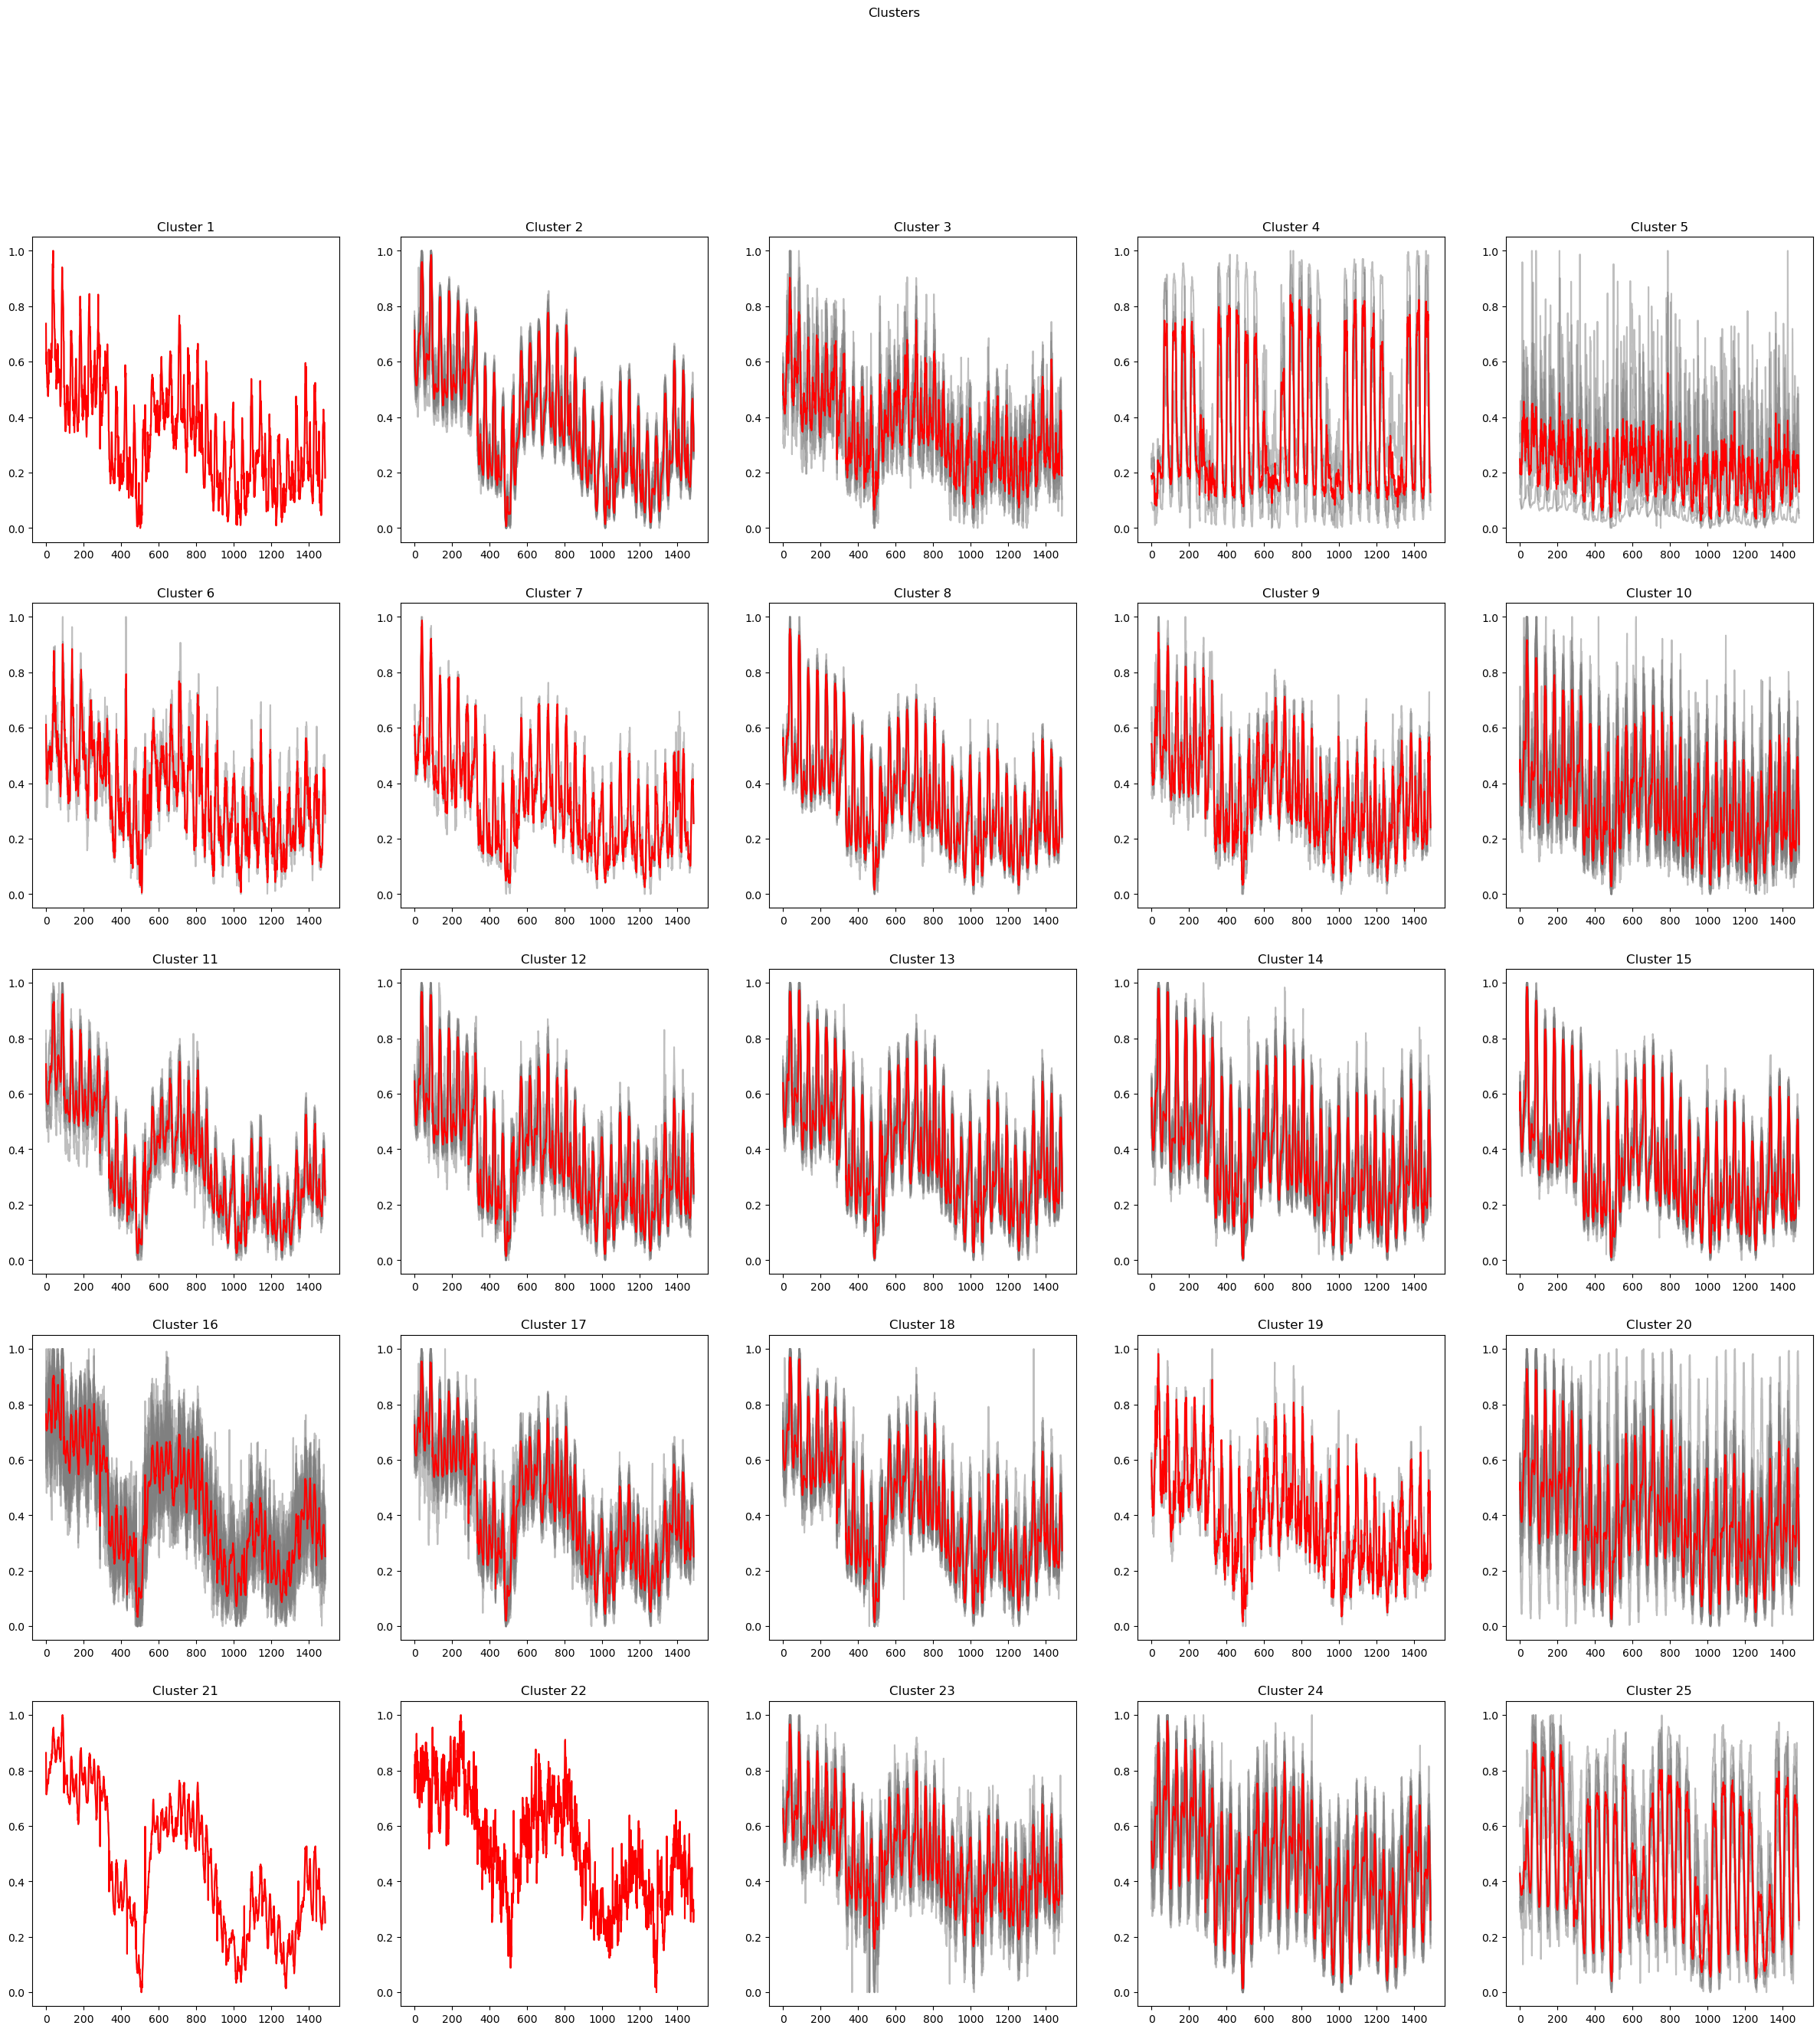

In [38]:
win_map = som.win_map(mySeries)
# Returns the mapping of the winner nodes and inputs

plot_som_series_averaged_center(som_x, som_y, win_map)

In [39]:
cluster_map = []
for idx in range(len(mySeries)):
    winner_node = som.winner(mySeries[idx])
    cluster_map.append((namesofMySeries[idx],f"Cluster {winner_node[0]*som_y+winner_node[1]+1}"))

df_clusters = pd.DataFrame(cluster_map,columns=["Series","Cluster"]).sort_values(by="Cluster").set_index("Series").reset_index()

df_clusters.Cluster.value_counts()

Cluster 14    44
Cluster 16    30
Cluster 13    28
Cluster 20    27
Cluster 2     25
Cluster 18    25
Cluster 17    20
Cluster 24    20
Cluster 15    18
Cluster 10    17
Cluster 12    16
Cluster 23    11
Cluster 11     8
Cluster 8      7
Cluster 3      6
Cluster 25     6
Cluster 5      5
Cluster 4      4
Cluster 9      4
Cluster 6      2
Cluster 7      2
Cluster 19     2
Cluster 22     1
Cluster 21     1
Cluster 1      1
Name: Cluster, dtype: int64

## K-Means Clustering

In [40]:
cluster_count = math.ceil(math.sqrt(len(mySeries)))
km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw")
labels = km.fit_predict(mySeries)

In [46]:
sil_sc = []
cluster_counts = [2,5,7,10,13,15,17,20,25,30,35]
for cluster_count in cluster_counts:
    km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw")
    labels = km.fit_predict(mySeries)
    sil_sc.append(silhouette_score(mySeries, labels, metric='dtw'))

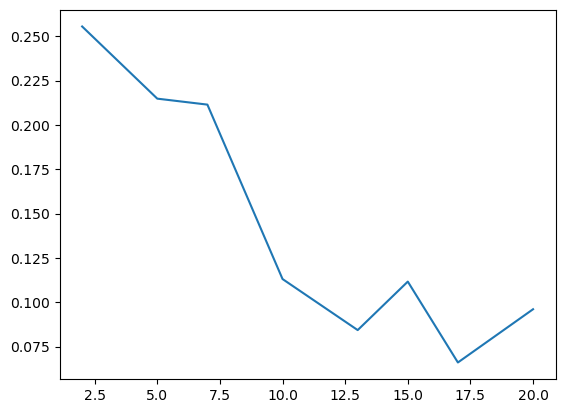

In [47]:
plt.plot(cluster_counts, sil_sc)

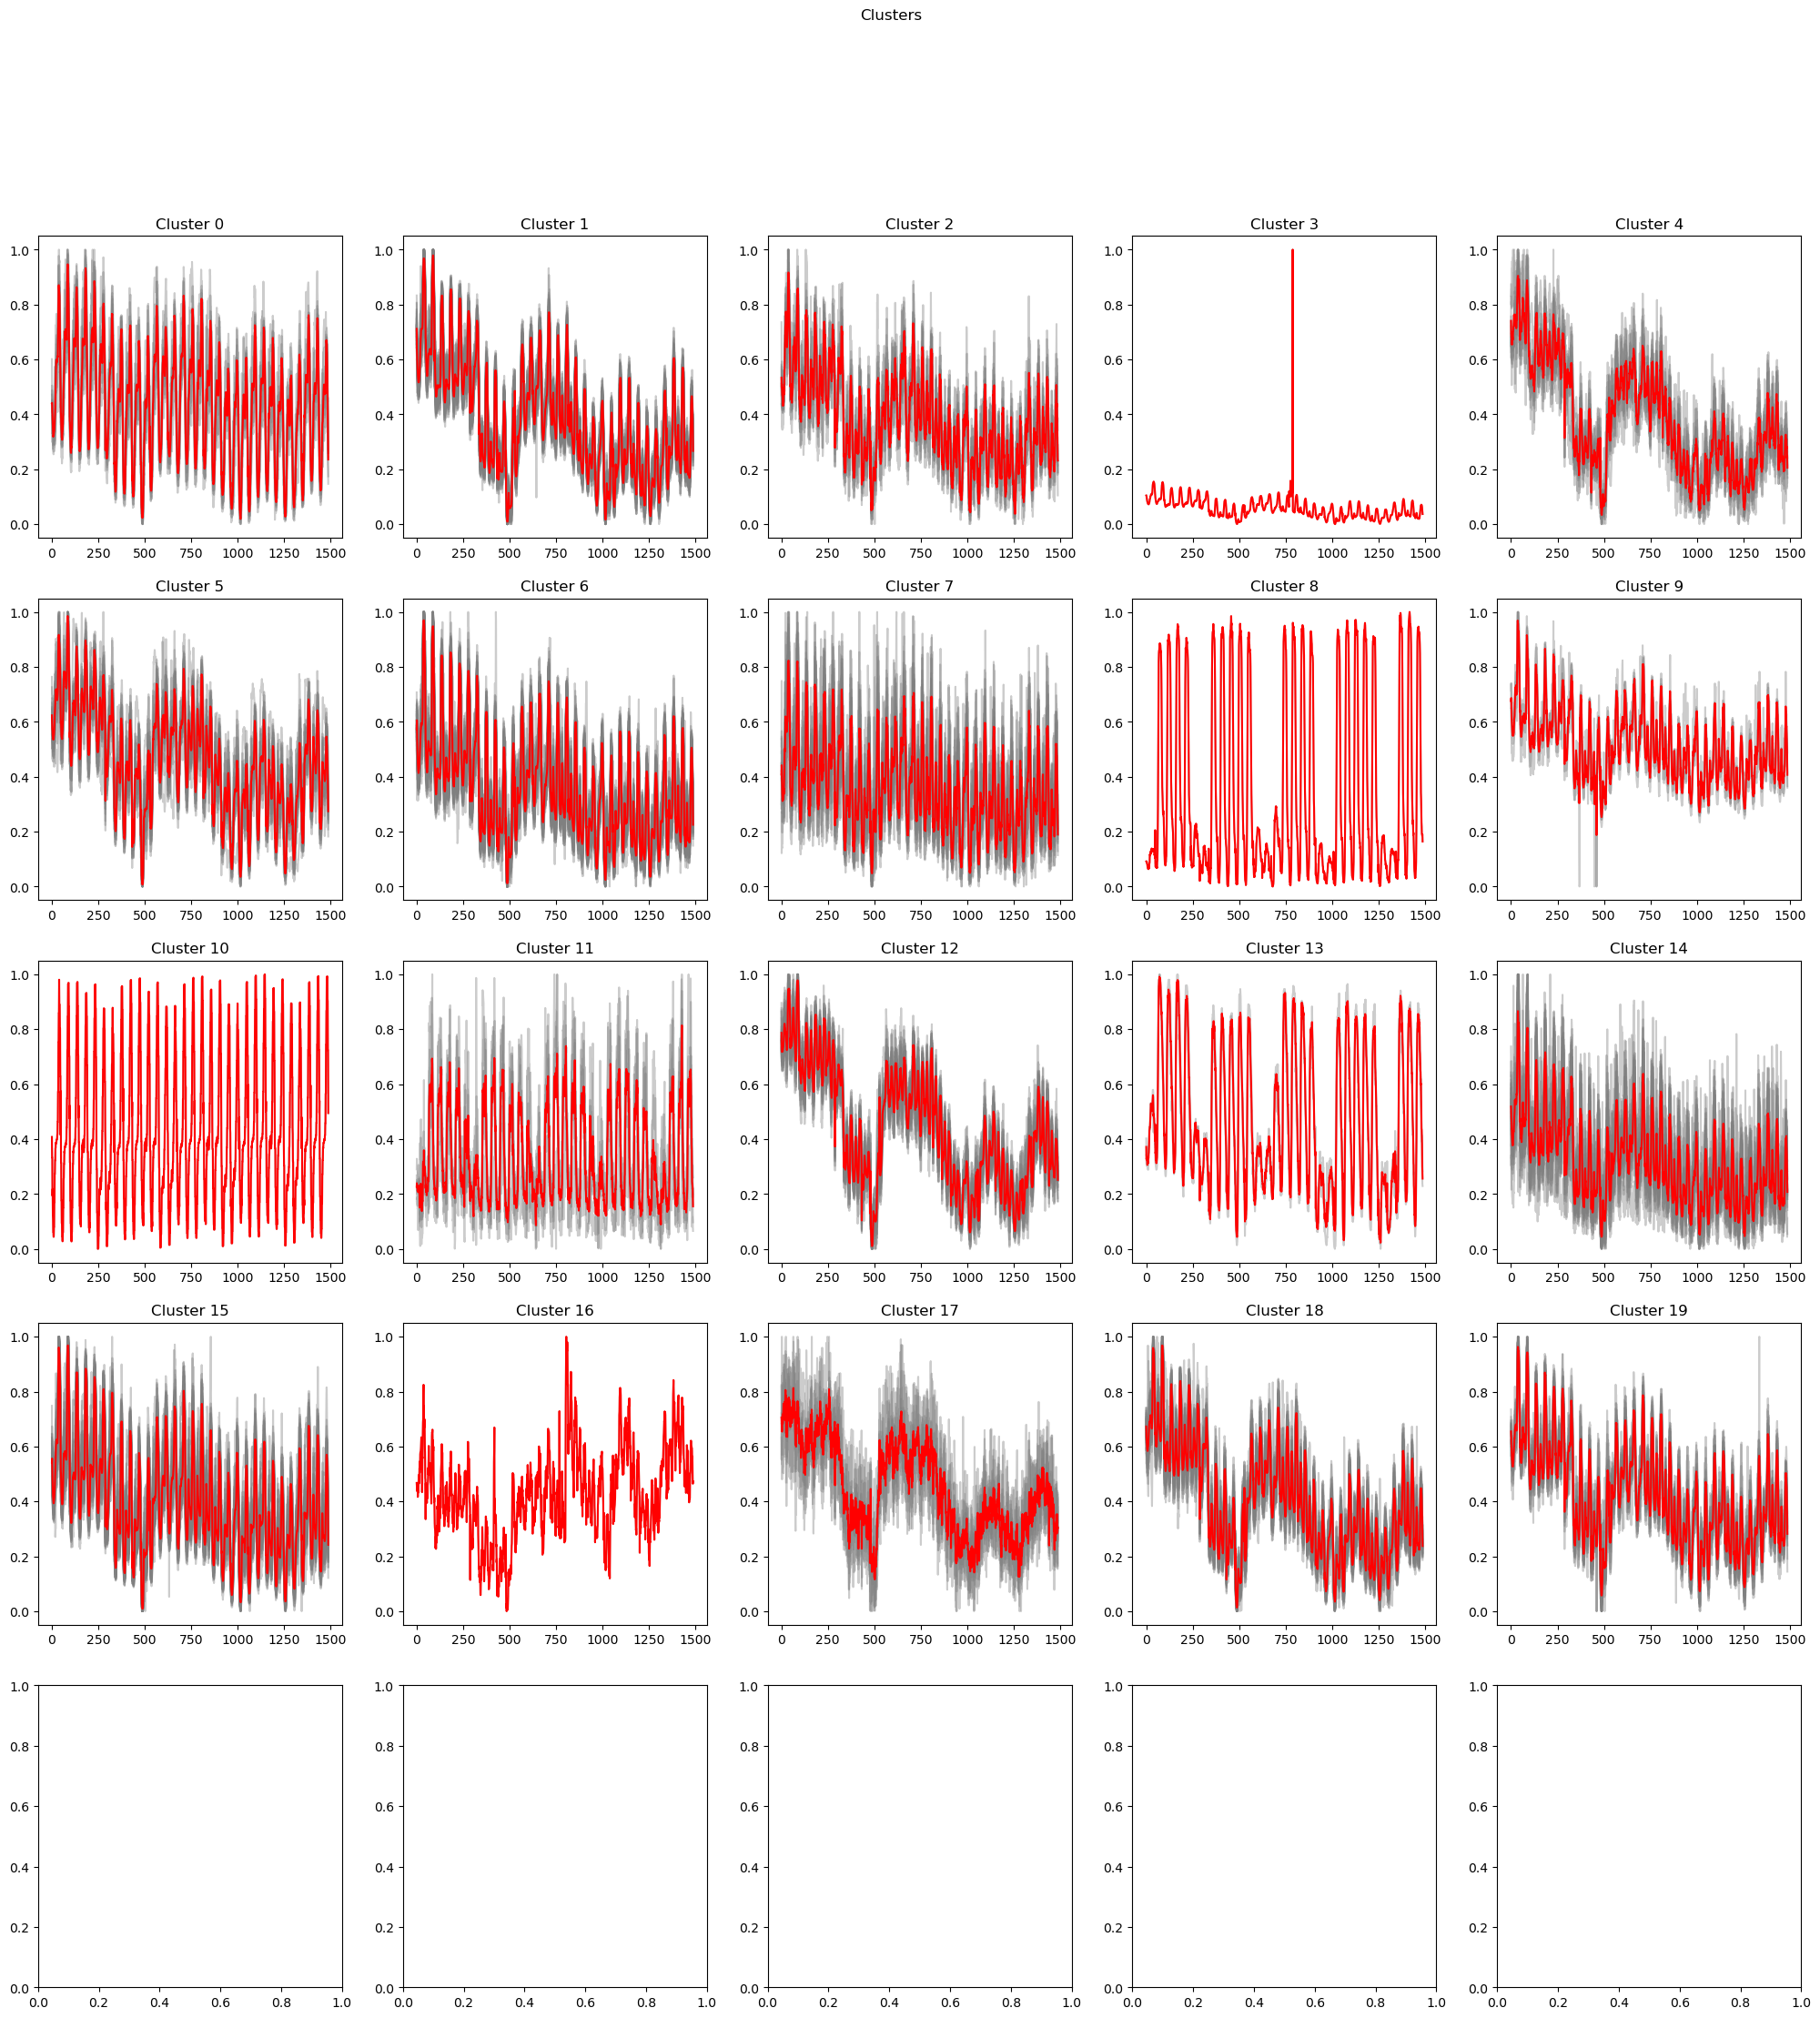

In [48]:
plot_count = math.ceil(math.sqrt(cluster_count))
fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(mySeries[i],c="gray",alpha=0.4)
                cluster.append(mySeries[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

Whole year: 2019
Important months: January, July, April
Week: July 15-21, January 28-Feb3, April 15-21
Day: 
    work: January 30, July 10, 8 April
    weekend: January 26, July 20, 7 April






